# Landsat 8 Product Page - AWS Level 1 Real Time Data 

This notebook contains general information about the landsat 8 satellite and demonstrates how to retrieve and visualise indexed landsat 8 products.

## About the Landsat Missions

"Landsat represents the world's longest continuously acquired collection of space-based moderate-resolution land remote sensing data. Four decades of imagery provides a unique resource for those who work in agriculture, geology, forestry, regional planning, education, mapping, and global change research. Landsat images are also invaluable for emergency response and disaster relief." [[1](#References)] 

"In the mid-1960s an ambitious effort to develop and launch the first civilian Earth observation satellite was started. The goal was achieved on July 23, 1972, with the launch of the Earth Resources Technology Satellite (ERTS-1), which was later renamed Landsat 1. The launches of Landsat 2, Landsat 3, and Landsat 4 followed in 1975, 1978, and 1982, respectively. When Landsat 5 was launched in 1984, no one could have predicted that the satellite would continue to deliver high quality, global data of Earth's land surfaces for 28 years and 10 months until its retirement in June, 2013. Landsat 6, however, failed to achieve orbit in 1993. Landsat 7 was successfully launched in 1999 and, along with Landsat 8 launched in 2013, continues to provide daily global data. Landsat 9 is planned to be launched in late 2020." [[2](#References)]

<img src="images/TimelineOnlyForWebRGB.jpg">
Fig 1. Time-line of the working lives of Landsats since 1972

## Landsat 8
The Landsat 8 satellite images the entire Earth every 16 days in an 8-day offset from Landsat 7. Providing moderate-resolution imagery, from 15 meters to 100 meters, of Earth's land surface and polar regions. The Landsat 8 mission objective is to provide timely, high quality visible and infrared images of all landmass and near-coastal areas on the Earth, continually refreshing an existing Landsat database. Landsat 8 operates in the visible, near-infrared, short wave infrared, and thermal infrared spectrums. Landsat 8 captures more than 700 scenes a day. 

Landsat - 8 Contains two instruements - Operational Land Imager (OLI) and Thermal Infrared Sensor (TIRS). Data captured by these sensors is organised in the following bands.

|Landsat - 8 OLI and TIRS Bands (um)| Name|Useful for|
|----|----|----|
|30m Coastal/ Aerosol 0.435 - 0.451|Band 1|Coastal and aerosol studies|
|30m Blue 0.452 - 0.512|Band 2|Bathymetric mapping, distinguishing soil from vegetation, and deciduous from coniferous vegetation|
|30m Green 0.533 - 0.590|Band 3|Emphasizes peak vegetation, which is useful for assessing plant vigor
|
|30m Red 0.636 - 0.673|Band 4|Discriminates vegetation slopes|
|30m NIR 0.851 - 0.879|Band 5|Emphasizes biomass content and shorelines|
|30m SWIR 1 1.566- 0.651|Band 6|Discriminates moisture content of soil and vegetation; penetrates thin clouds|
|30m SWIR 2 2.107 - 2.294|Band 7|Improved moisture content of soil and vegetation and thin cloud penetration|
|15m Pancromatic 0.503 - 0.676|Band 8|15 meter resolution, sharper image definition|
|30m Cirrus 1.363 - 1.384|Band 9|Improved detection of cirrus cloud contamination|
|100m TIRS 1 10.6 - 11.19|Band 10|100 meter resolution, thermal mapping and estimated soil moisture|
|100m TIRS 2 11.5 - 12.51|Band 11|100 meter resolution, Improved thermal mapping and estimated soil moisture|

<img src="images/MSS-thru-L9-wavelengths.jpg">
Fig 2. Landsat 8 Spectral Bands and Wavelengths compared to Landsat 7 ETM+

A Quality Assessment band is also included with each Landsat 8 data product. This band allows users to apply per pixel filters to the Landsat 8 Operational Land Imager (OLI)-only and Landsat 8 OLI/Thermal Infrared Sensor (OLI/TIRS)-combined data products.




### Import modules

In [2]:
# %matplotlib inline
import sys
import warnings
import datacube
import matplotlib.pyplot as plt
from datacube.storage import masking
from utils.utils import (
    lat_lon_to_epsg,
    three_band_image,
    load_config_extents,
    transform_to_wgs,
    load_config)



### Available Landsat products
The `list_products` method in the Datacube class displays the names and details of all available products. In the below cell we will query what Landsat 8 Products are currently indexed in our instance.

In [3]:
# Connect to a datacube
dc = datacube.Datacube(app='Intro to Landsat')

# List metadata for all Landsat NBAR and NBART products available in DEA
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
dc_products[dc_products['name'].str.contains("ls8|ls8")][display_columns].set_index('name')


description  \
name                                                                            
ls8_collection1_AMA_ingest  Landsat 8 USGS Collection 1 Higher Level SR sc...   
ls8_l1_pc_usgs                 Landsat 8 USGS Level 1 Pre-Collection OLI-TIRS   
ls8_level1_usgs                  Landsat 8 USGS Level 1 Collection-1 OLI-TIRS   
ls8_usgs_sr_scene           Landsat 8 USGS Collection 1 Higher Level SR sc...   

                           product_type  crs  resolution  spatial_dimensions  
name                                                                          
ls8_collection1_AMA_ingest        LaSRC  NaN         NaN                 NaN  
ls8_l1_pc_usgs                      L1T  NaN         NaN                 NaN  
ls8_level1_usgs                    L1TP  NaN         NaN                 NaN  
ls8_usgs_sr_scene           LEVEL2_USGS  NaN         NaN                 NaN

### Landsat 8 Products

Acquired landsat 8 data undergo a number of processing steps before it can be used for any applications, processing includes geometric algorithms to use the Earth ellipsoid and terrain surface information in conjunction with spacecraft ephemeris and attitude data, and knowledge of the OLI and TIRS instruments and L8 satellite geometry, to relate locations in image space (band, detector, sample) to geodetic object space (latitude, longitude, and elevation).

These algorithms are used to create three level tiers of products and are reffered to as Level 1 output products, data within these products are broken down into Tier 1, Tier 2, and Real-Time. 

Data in Tier 1 meet formal geometric and radiometric quality criteria. Tier 2 do not meet the Tier 1 criteria. The Real-Time Tier contains data immediately after acquisitions that use estimated parameters. Real-Time data are reprocessed and assessed for inclusion into Tier 1 or Tier 2 as soon as final parameters are available.

### Landsat 8 Collection 1 Level 1 Real-time Data on AWS

AWS stores a complete world wide archive of Real Time data, see https://docs.opendata.aws/landsat-pds/readme.html. This data as is real time level 1 meaning, it is data immediately after acquisitions that uses estimated parameters to relate locations in image space to geodetic object space.

We have indexed the full archive, and have added the product as 'ls8_level1_usgs' in our instance of ODC.

<img src="images/indexed_areas.png">
Fig 3. You are able to access any area marked out in yellow with real time data from our ODC instance.




### Below is a demonstration of how to access this data using the ODC python api, if you're not a data python user you can use our data exploration notebooks to use this data.

In [6]:
## Let's load some real time data and visualise it.

#You can change these coordinates and time to suit what you'd like

lon_min,lon_max,lat_min,lat_max = [144.8,145,-37.65,-37.75]
date_range = ("2018-01-01","2018-03-06")

# Get the EPSG of a WGS UTM coordinate reference system that is appropriate for our data
EPSG = lat_lon_to_epsg(lat_max,lon_min)

#We're going to request a data cube projected into the local UTM zone.

data_cube = dc.load(
    product='ls8_level1_usgs',
    x=(lon_min, lon_max),
    y=(lat_min, lat_max), 
    output_crs='epsg:' + EPSG,
    resolution=(-30, 30),
    time = date_range)
data_cube

<xarray.Dataset>
Dimensions:          (time: 7, x: 597, y: 384)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-09T00:03:33.497839 ...
  * y                (y) float64 5.831e+06 5.831e+06 5.831e+06 5.831e+06 ...
  * x                (x) float64 3.059e+05 3.06e+05 3.06e+05 3.06e+05 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 10468 10412 10381 10371 10401 10397 ...
    blue             (time, y, x) int16 9372 9320 9299 9285 9338 9333 9375 ...
    green            (time, y, x) int16 8063 8005 7968 7994 8061 8083 8140 ...
    red              (time, y, x) int16 7565 7462 7462 7530 7622 7648 7700 ...
    nir              (time, y, x) int16 9194 8914 8933 8820 9021 9119 9394 ...
    swir1            (time, y, x) int16 9187 8937 8876 8827 8864 8983 9091 ...
    swir2            (time, y, x) int16 7135 7104 7023 7034 7036 7115 7287 ...
    panchromatic     (time, y, x) int16 7958 7794 7763 7794 7865 7932 7879 ...
    cirrus           (time, y, x) int16 5053 5068

The data has been returned to us as a data cube, to find out more about what a datacube is please run the ODC Functionality notebook.

Let's use the quality band to filter out all areas where cloud and saturation is present.

In [7]:
# Create mask around all pixels deemed good according to parameters around cloud cover and saturation.
clean_pixel_mask = masking.make_mask(
    data_cube.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion = False)
masked_cloud = data_cube.where(clean_pixel_mask)


### Creating a 'true colour' image using three bands
We can also plot combinations of multiple bands as a colour RGB image by converting the xarray dataset to a three band data array, using `.isel(time=1)` to pull out a single time-step to plot, then using the `.plot.imshow` method to plot.

By specifying the `red`, `green` and `blue` bands, we can produce a ['true colour' plot](https://crisp.nus.edu.sg/~research/tutorial/opt_int.htm) that approximates how the landscape would appear to the human eye. Note however that below we use the `robust=True` argument to remove extreme values and result in a colour-enhanced image:

Landsat 8 measurement band measurements are:

             ('1', 'coastal_aerosol')
             ('2', 'blue')
             ('3', 'green')
             ('4', 'red')
             ('5', 'nir')
             ('6', 'swir1')
             ('7', 'swir2')
             ('8', 'panchromatic')
             ('9', 'cirrus')
             ('10', 'lwir1')
             ('11', 'lwir2')
             ('QUALITY', 'quality')]


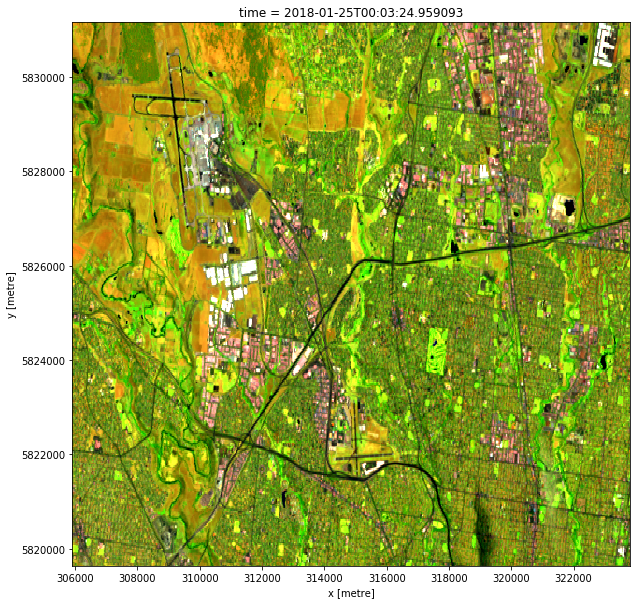

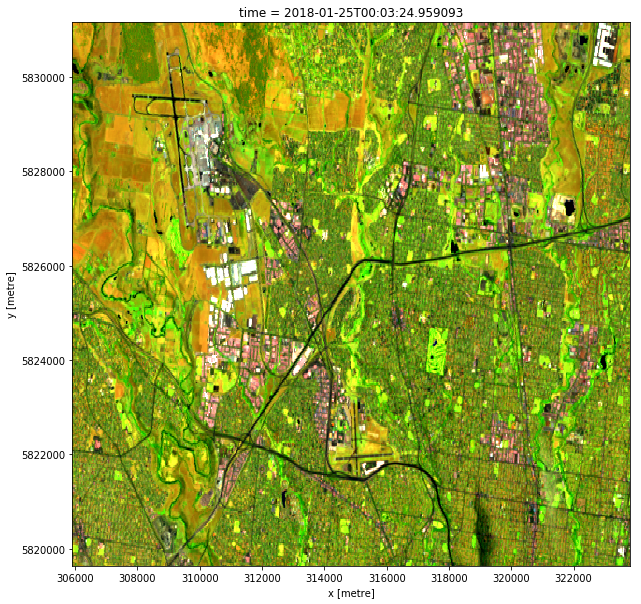

In [8]:
# change the measurements to explore true colour or false colour three band images

#bands = ['red', 'green', 'blue'] #True Colour
bands = ['swir1', 'nir', 'green'] #False Colour

#change time step to run through time, below will display both an image 
#with clouds and with clouds filtered out}
time_step = 2

data_cube[bands].isel(time=time_step).to_array().plot.imshow(robust=True, figsize=(10, 10))
masked_cloud[bands].isel(time=time_step).to_array().plot.imshow(robust=True, figsize=(10, 10))

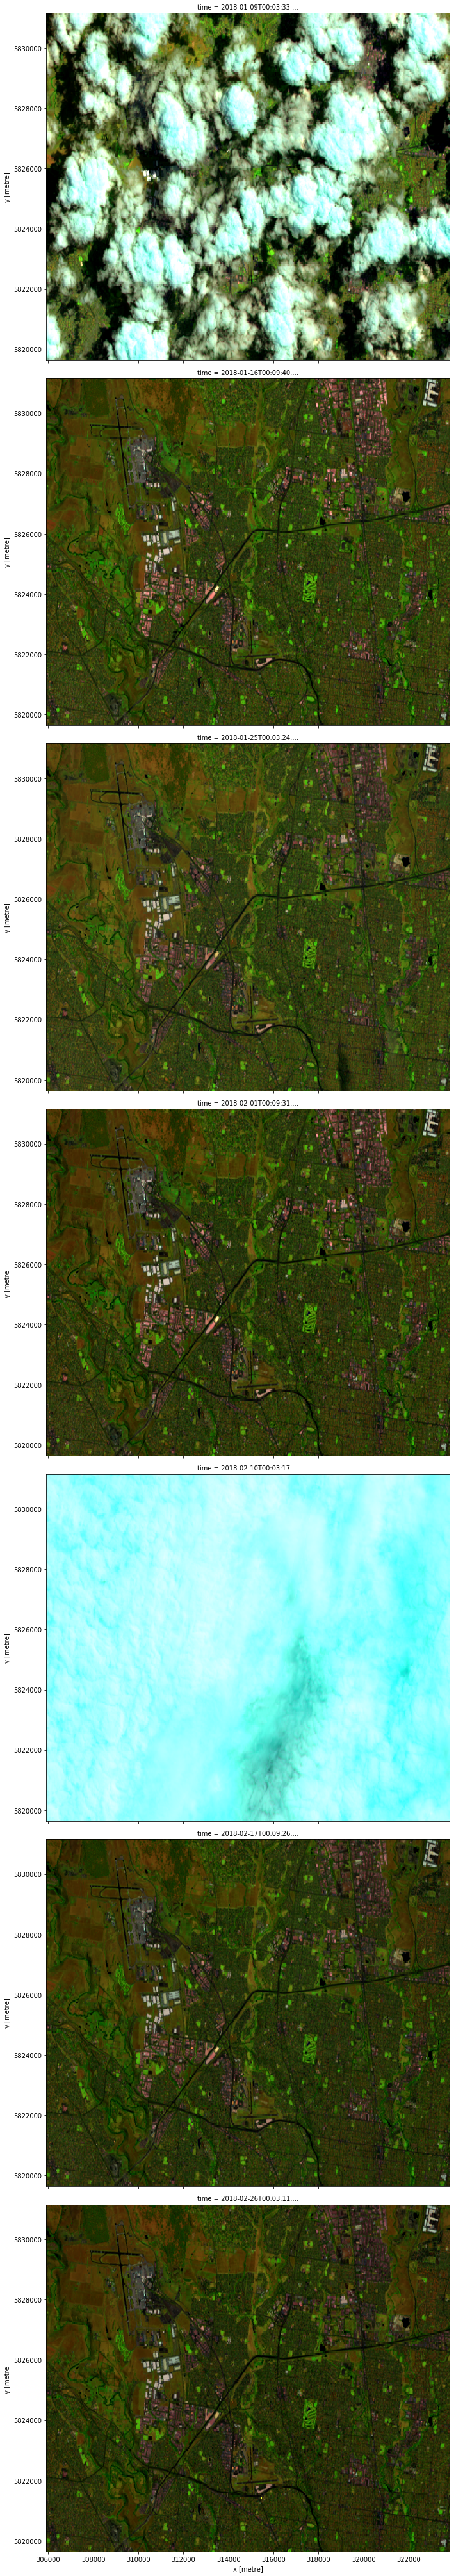

In [9]:
# change the measurements to explore true colour or false colour three band images

#bands = ['red', 'green', 'blue'] #True Colour
bands = ['swir1', 'nir', 'green'] #False Colour

no_time_steps = len(data_cube.time)

data_cube[bands].isel(time=list(range(no_time_steps))).to_array().plot.imshow(row='time', robust=True,figsize=(10, 8*no_time_steps))

### References

1. USGS, 2018a. *Landsat Project Description | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm. <https://landsat.usgs.gov/landsat-project-description>
2. USGS, 2018b. *Landsat Missions Timeline | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-missions-timeline>
3. USGS, 2018c. *Landsat 5 History | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-5-history>
4. USGS, 2018d. *Landsat 6 History | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-6-history>
5. USGS, 2018e. *Landsat 7 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-7-history>
6. USGS, 2018f. *Landsat 8 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-8-mission>
7. USGS, 2018g. *Landsat 9 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-9-mission>
8. USGS, 2018h. *Landsat 7 Data Users Handbook - Section 2 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-7-data-users-handbook-section-2>

